This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [2]:
!pip install tensorflow==2.12
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 32.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.1

**Inspecting the data of the Jena weather dataset**

In [4]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [5]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

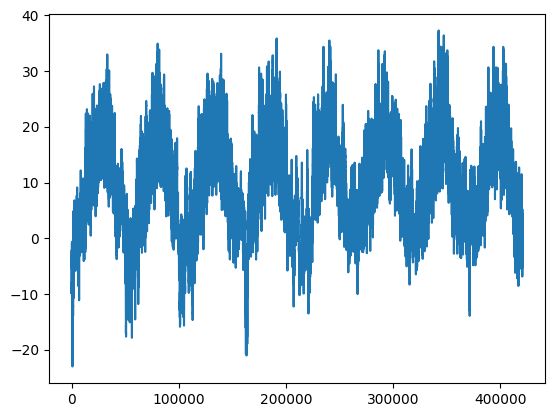

In [6]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

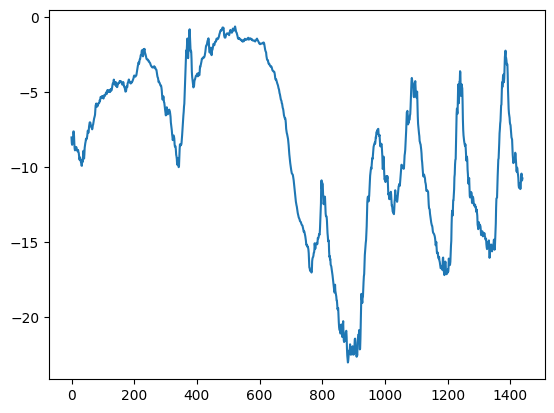

In [7]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [8]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [9]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [10]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [15]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [16]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [14]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [17]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 62s 75ms/step - loss: 14.0544 - mae: 2.8888 - val_loss: 12.8480 - val_mae: 2.8460
Epoch 2/10
819/819 [==============================] - 54s 66ms/step - loss: 9.4597 - mae: 2.4183 - val_loss: 10.9226 - val_mae: 2.6281
Epoch 3/10
819/819 [==============================] - 63s 76ms/step - loss: 8.5998 - mae: 2.3097 - val_loss: 10.2550 - val_mae: 2.5337
Epoch 4/10
819/819 [==============================] - 58s 70ms/step - loss: 8.0630 - mae: 2.2354 - val_loss: 10.6378 - val_mae: 2.5790
Epoch 5/10
819/819 [==============================] - 57s 69ms/step - loss: 7.7023 - mae: 2.1854 - val_loss: 10.5950 - val_mae: 2.5826
Epoch 6/10
819/819 [==============================] - 61s 74ms/step - loss: 7.4347 - mae: 2.1488 - val_loss: 10.6400 - val_mae: 2.5802
Epoch 7/10
819/819 [==============================] - 56s 68ms/step - loss: 7.2460 - mae: 2.1223 - val_loss: 11.8778 - val_mae: 2.7360
Epoch 8/10
819/819 [==============================] - 

**Plotting results**

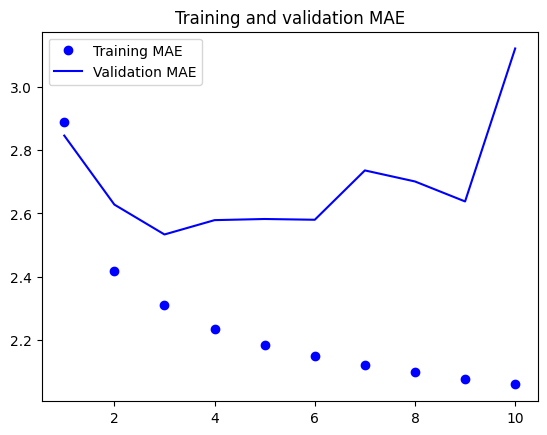

In [18]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 124s 150ms/step - loss: 31.8338 - mae: 4.2604 - val_loss: 19.3086 - val_mae: 3.4976
Epoch 2/10
819/819 [==============================] - 100s 121ms/step - loss: 16.7205 - mae: 3.2450 - val_loss: 14.4390 - val_mae: 2.9945
Epoch 3/10
819/819 [==============================] - 98s 118ms/step - loss: 15.2101 - mae: 3.0924 - val_loss: 14.3897 - val_mae: 2.9858
Epoch 4/10
819/819 [==============================] - 98s 119ms/step - loss: 14.4111 - mae: 3.0073 - val_loss: 14.2955 - val_mae: 2.9748
Epoch 5/10
819/819 [==============================] - 97s 119ms/step - loss: 13.7539 - mae: 2.9327 - val_loss: 17.3769 - val_mae: 3.2466
Epoch 6/10
819/819 [==============================] - 101s 123ms/step - loss: 13.1239 - mae: 2.8636 - val_loss: 14.2634 - val_mae: 2.9497
Epoch 7/10
819/819 [==============================] - 102s 124ms/step - loss: 12.6332 - mae: 2.8102 - val_loss: 14.1823 - val_mae: 2.9587
Epoch 8/10
819/819 [=================

### A first recurrent baseline

**A simple LSTM-based model**

In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 141s 169ms/step - loss: 45.4019 - mae: 4.9189 - val_loss: 13.1697 - val_mae: 2.7303
Epoch 2/10
819/819 [==============================] - 138s 168ms/step - loss: 11.0524 - mae: 2.5772 - val_loss: 9.8125 - val_mae: 2.4193
Epoch 3/10
819/819 [==============================] - 121s 148ms/step - loss: 9.6576 - mae: 2.4209 - val_loss: 9.6998 - val_mae: 2.4110
Epoch 4/10
819/819 [==============================] - 140s 170ms/step - loss: 9.1477 - mae: 2.3589 - val_loss: 9.6465 - val_mae: 2.3972
Epoch 5/10
819/819 [==============================] - 140s 171ms/step - loss: 8.8046 - mae: 2.3153 - val_loss: 9.6982 - val_mae: 2.4001
Epoch 6/10
819/819 [==============================] - 137s 167ms/step - loss: 8.5288 - mae: 2.2809 - val_loss: 10.1105 - val_mae: 2.4447
Epoch 7/10
819/819 [==============================] - 141s 171ms/step - loss: 8.2966 - mae: 2.2509 - val_loss: 10.3393 - val_mae: 2.4737
Epoch 8/10
819/819 [=======================

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [21]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [22]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [23]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [24]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [25]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [27]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 281s 336ms/step - loss: 25.3285 - mae: 3.7458 - val_loss: 9.8182 - val_mae: 2.4319
Epoch 2/10
819/819 [==============================] - 263s 321ms/step - loss: 14.6897 - mae: 2.9675 - val_loss: 9.5585 - val_mae: 2.4035
Epoch 3/10
819/819 [==============================] - 266s 324ms/step - loss: 13.8737 - mae: 2.8871 - val_loss: 9.5683 - val_mae: 2.4086
Epoch 4/10
819/819 [==============================] - 255s 311ms/step - loss: 13.1896 - mae: 2.8119 - val_loss: 9.5077 - val_mae: 2.3922
Epoch 5/10
819/819 [==============================] - 261s 319ms/step - loss: 12.7106 - mae: 2.7612 - val_loss: 9.4786 - val_mae: 2.4015
Epoch 6/10
819/819 [==============================] - 283s 345ms/step - loss: 12.4026 - mae: 2.7248 - val_loss: 9.3175 - val_mae: 2.3688
Epoch 7/10
819/819 [==============================] - 268s 327ms/step - loss: 12.0996 - mae: 2.6947 - val_loss: 9.3509 - val_mae: 2.3799
Epoch 8/10
819/819 [=====================

In [28]:
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 45s 110ms/step - loss: 10.6578 - mae: 2.5938
Test MAE: 2.59


In [29]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU(32)
 model**

In [30]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru32_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru32_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 532s 644ms/step - loss: 25.1347 - mae: 3.6998 - val_loss: 9.4276 - val_mae: 2.3808
Epoch 2/10
819/819 [==============================] - 467s 570ms/step - loss: 14.2009 - mae: 2.9164 - val_loss: 9.0517 - val_mae: 2.3303
Epoch 3/10
819/819 [==============================] - 474s 579ms/step - loss: 13.3156 - mae: 2.8284 - val_loss: 8.8760 - val_mae: 2.3078
Epoch 4/10
819/819 [==============================] - 467s 569ms/step - loss: 12.7756 - mae: 2.7763 - val_loss: 8.7492 - val_mae: 2.2944
Epoch 5/10
819/819 [==============================] - 466s 569ms/step - loss: 12.2413 - mae: 2.7158 - val_loss: 8.8851 - val_mae: 2.3108
Epoch 6/10
819/819 [==============================] - 464s 566ms/step - loss: 11.8463 - mae: 2.6707 - val_loss: 8.7025 - val_mae: 2.2872
Epoch 7/10
819/819 [==============================] - 468s 572ms/step - loss: 11.4446 - mae: 2.6290 - val_loss: 8.7292 - val_mae: 2.3002
Epoch 8/10
819/819 [=====================

**Training and evaluating a dropout-regularized, stacked GRU mode(16)**



In [31]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(16, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru16_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru16_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 319s 384ms/step - loss: 46.0969 - mae: 5.0154 - val_loss: 13.3380 - val_mae: 2.7111
Epoch 2/10
819/819 [==============================] - 316s 385ms/step - loss: 18.6758 - mae: 3.2995 - val_loss: 9.8854 - val_mae: 2.4377
Epoch 3/10
819/819 [==============================] - 309s 377ms/step - loss: 17.1263 - mae: 3.1730 - val_loss: 9.0487 - val_mae: 2.3313
Epoch 4/10
819/819 [==============================] - 309s 377ms/step - loss: 16.3375 - mae: 3.1000 - val_loss: 9.1751 - val_mae: 2.3420
Epoch 5/10
819/819 [==============================] - 316s 385ms/step - loss: 15.7094 - mae: 3.0395 - val_loss: 9.2059 - val_mae: 2.3637
Epoch 6/10
819/819 [==============================] - 310s 378ms/step - loss: 15.2392 - mae: 2.9999 - val_loss: 8.8959 - val_mae: 2.3156
Epoch 7/10
819/819 [==============================] - 309s 376ms/step - loss: 14.7266 - mae: 2.9509 - val_loss: 8.5843 - val_mae: 2.2732
Epoch 8/10
819/819 [====================

**Training and evaluating a dropout-regularized, stacked LSTM(32) model**

In [32]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_lstm32_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_lstm32_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 532s 643ms/step - loss: 26.6970 - mae: 3.8068 - val_loss: 9.5109 - val_mae: 2.3842
Epoch 2/10
819/819 [==============================] - 529s 646ms/step - loss: 13.7018 - mae: 2.8694 - val_loss: 9.4251 - val_mae: 2.3984
Epoch 3/10
819/819 [==============================] - 535s 653ms/step - loss: 12.5070 - mae: 2.7383 - val_loss: 9.2721 - val_mae: 2.3796
Epoch 4/10
819/819 [==============================] - 522s 638ms/step - loss: 11.5472 - mae: 2.6299 - val_loss: 9.6565 - val_mae: 2.4534
Epoch 5/10
819/819 [==============================] - 526s 642ms/step - loss: 10.8664 - mae: 2.5464 - val_loss: 9.7187 - val_mae: 2.4477
Epoch 6/10
819/819 [==============================] - 527s 643ms/step - loss: 10.2189 - mae: 2.4743 - val_loss: 9.9956 - val_mae: 2.4825
Epoch 7/10
819/819 [==============================] - 529s 645ms/step - loss: 9.6892 - mae: 2.4076 - val_loss: 10.5126 - val_mae: 2.5383
Epoch 8/10
819/819 [=====================

**Training and evaluating a dropout-regularized, stacked LSTM(16) model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(16, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_lstm16_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_lstm16_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

### 1D and LSTM32


In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv_lstm.keras", save_best_only=True)
]

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 151s 177ms/step - loss: 28.7749 - mae: 4.0590 - val_loss: 22.2322 - val_mae: 3.7770
Epoch 2/10
819/819 [==============================] - 148s 180ms/step - loss: 15.8907 - mae: 3.1303 - val_loss: 21.5993 - val_mae: 3.6712
Epoch 3/10
819/819 [==============================] - 162s 197ms/step - loss: 13.5041 - mae: 2.8682 - val_loss: 21.2584 - val_mae: 3.7035
Epoch 4/10
819/819 [==============================] - 163s 199ms/step - loss: 11.9904 - mae: 2.6946 - val_loss: 22.9238 - val_mae: 3.7766
Epoch 5/10
819/819 [==============================] - 157s 192ms/step - loss: 10.8841 - mae: 2.5570 - val_loss: 21.5487 - val_mae: 3.7215
Epoch 6/10
819/819 [==============================] - 157s 192ms/step - loss: 10.0314 - mae: 2.4446 - val_loss: 27.9855 - val_mae: 4.1387
Epoch 7/10
819/819 [==============================] - 145s 176ms/step - loss: 9.4404 - mae: 2.3632 - val_loss: 22.6031 - val_mae: 3.7901
Epoch 8/10
 12/819 [...............

**Training and evaluating a bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

### Going even further

## Summary